# Deep Learning assignment #1

In this first assignment of the *Deep Learning course*, you will be challenged to reproduce some experiments from the seminal paper that (probably) gave rise to the entire field of *Deep Learning*. Even though the experiments are definitely simple for today’s standards, their setup and execution may kickstart unexpectedly *deep* considerations about the subject.

The list that follow should provide you with essential guidance on how the assignment should be carried on.

1.   Read carefully the paper [*“Learning representations by back-propagating errors” (Rumelhart et al., 1986)*](https://bucket.ballarin.cc/papers/oth/rumelhart1986.pdf). Read it in its entirety, but focus specifically on the experiment outlined in *Fig. 1* (learning mirror symmetries in 6-digits numbers).

2.   Reproduce in `PyTorch` (or any other *DL* library you are confident using) such experiment. Try to be as close as possible to the original protocol, with respect to network architecture, activation functions, learning algorithm and parameter initialization.

3.   Assess model accuracy, and inspect the weights of the trained network. Do they provide a solution to the problem?

4.   Compare the solution to the one reported in the original paper. Comment.
5.   **Optional:** you are warmly encouraged to explore and discuss additional variations to the experimental details and the results they produce on final accuracy and weights of the network. Some of such changes may include (but are not limited to):
     -   changing the activation functions of the network;
     -   changing the optimizer and/or its hyperparameters;
     -   adding a learning rate scheduler, *etc.*

Write a short report (approx. 1 page long) about your experimentation and reproduction results, and what such experience had made you learn. The final document should be a `jupyter` notebook containing both the report and the code cells necessary to reproduce your experiments. Please, also comment any nontrivial parts of your code.

**N.B.:** The very goal of this assignment is **not** that of exactly reproducing the results of the original paper. There are no *correct* or *incorrect* choices, as long as they are reasonable, convincing, and justified. Approach the problem with an open mind, and – most importantly – enjoy the journey!



You can send your `jupyter` notebook in any digital format you prefer (`ipynb`, `html`, `pdf`) as an attachment to [emanuele@ballarin.cc](mailto:emanuele@ballarin.cc), by **the end of May 7, 2024**.

You can also use the same email address for any question related to the assignment. If you have more general questions or doubts about the assignment itself, the paper, or any other part of the course seen until now, please also include Prof. Ansuini in the conversation ([alessio.ansuini@areasciencepark.it](mailto:alessio.ansuini@areasciencepark.it)).



**P.S.:** The code of your notebook is expected to run in compatibility with the latest version of `PyTorch` (*i.e.* `2.2.2`). If you require the use of any different version (or any different or additional library), please, specify it or make it clear from your comments. Thanks!


## Initialization Constants

In [11]:
import torch as th
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from itertools import product

from tqdm.auto import trange

import matplotlib.pyplot as plt

In [12]:
device: th.device = th.device("cuda" if th.cuda.is_available() else "cpu")
CRITERION = (th.nn.MSELoss())
LR: float = 0.1
DECAY: float = 0.9
BATCH_SIZE: int = 64

## Data Generation

To understand if an input data is ismmetric we can just check if the first value is equal to the last, the second to the second-last and so on

In [13]:
def is_simmetric(tensor: th.tensor):
    # Allocate the output array
    simmetric = th.zeros((len(tensor), 1))
    d = tensor.shape[1]//2

    # For each row...
    for i, row in enumerate(tensor.numpy()):

        simmetric[i] = float((row[:d] == row[d:][::-1]).all())

    return simmetric

We can generate the simmetric data just keeping them from the randomly generated one

In [45]:
def generate_data(shape: tuple[int, int] = (10000, 6), low: int=0, high: int=10) -> tuple[th.tensor, th.tensor]:
    # Initialize the tensor
    data = th.tensor([])

    # While we don't have half row simmetric
    while len(data) < shape[0]//2:
        # Generate random rows and check if they are simmetric
        x_tmp = th.randint(low=low, high=high, size=shape)
        y_tmp = is_simmetric(x_tmp)

        # Take just the simmetric row
        y_tmp_ = y_tmp.reshape(-1).bool()
        simmetric_rows = x_tmp[y_tmp_]

        # Append to the tensor
        data = th.cat((data, simmetric_rows), dim=0)

    # Generate the other half rows
    # Generally few rows are simmetric, so the dataset will be nearly balanced
    not_simmetric = th.randint(low=0, high=10, size=data.shape)

    # Obtain the final dataset
    X = th.cat((data, not_simmetric), dim=0)
    y = is_simmetric(X).float

    return X, y

To generate all the possible combination of a binary array we can just use a cartesian product of the values

In [53]:
def generate_data_binary(dim: int = 6):
    # data = th.tensor([])

    ## Convert the binary representation of the values in array
    # for i in range(2**dim):
    #     idxs = np.array(list(bin(i).split("b")[1]))
    #     idxs = np.where(idxs == '1')[0] - len(idxs)

    #     new = th.zeros((1, dim))
    #     new[0, idxs] = 1

    #     data = th.cat((data, new))

    X = th.tensor(list(product([0,1], repeat=6))).float()

    y = is_simmetric(X)

    return X, y

We can define Dataset class for our data

In [16]:
class SimmetricData(Dataset):
    def __init__(self, X: th.tensor, y: th.tensor):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index: int):
        return self.X[index], self.y[index]

We can split the data into train and test set randomly chosing the indexes

In [17]:
def split_data(X: th.tensor, y: th.tensor, test_size: int | float = 0.2) -> tuple[th.tensor, th.tensor, th.tensor, th.tensor]:
    if test_size < 1:
        test_size = int(len(y)*test_size)

    test_idxs = np.random.choice(range(len(y)), size=test_size, replace=False)
    train_idxs = list(set(range(len(y))) - set(test_idxs))

    return X[train_idxs], X[test_idxs], y[train_idxs], y[test_idxs]

In [54]:
# X, y = generate_data(shape=(10000, 6), low=0, high=1)
X, y = generate_data_binary(dim=6)

In [55]:
train_idxs = np.random.choice(range(len(X)), 10000, replace=True)
test_idxs = np.random.choice(range(len(X)), 1000, replace=True)

In [56]:
X_train, X_test, y_train, y_test = split_data(X, y)
#X_train, X_test, y_train, y_test = X[train_idxs], X[test_idxs], y[train_idxs], y[test_idxs]

In [57]:
train_dataset: SimmetricData = SimmetricData(X_train, y_train)
test_dataset: SimmetricData = SimmetricData(X_test, y_test)

In [58]:
train_dataset: SimmetricData = SimmetricData(X, y)
test_dataset: SimmetricData = SimmetricData(X, y)

We can convert the Dataset class into DataLoader

In [59]:
train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader: DataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

We can notice that, generating all the 64 combinations of a binary array of size 6, the simmetric data are a lot less than the non-simmetric ones.

In [33]:
prop = round(y.sum().item()/y.shape[0], 3)
print(f"Total data: \t{len(y)}",
      f"Simmetric: \t{prop*100}%",
      f"Not Simmetric: \t{(1-prop)*100}%", sep="\n")

Total data: 	64
Simmetric: 	12.5%
Not Simmetric: 	87.5%


## Reproduction
We can define the model as the one defined from the paper. \\
This contains just one fully-connected hidden layer with two hidden units, and an output layer with just one output. \\
The used activation functions are the Sigmoids.

In [36]:
def generate_model(input_size: int) -> th.nn.Module:
    return th.nn.Sequential(
        th.nn.Linear(in_features=input_size, out_features=2, bias=True),
        th.nn.Sigmoid(),
        th.nn.Linear(in_features=2, out_features=1, bias=True),
        th.nn.Sigmoid(),
    )

In [37]:
def train_routine(model: th.nn.Module, criterion, optimizer: th.optim.Optimizer, train_loader: DataLoader, test_loader: DataLoader, epochs: int = 10):
    train_loss = th.zeros(epochs)
    train_accuracy = th.zeros(epochs)
    test_loss = th.zeros(epochs)
    test_accuracy = th.zeros(epochs)

    for epoch in trange(epochs):
        model.train()

        for (X, y) in train_loader:
            X, y = X.to(device), y.to(device)

            output = model(X)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        loss: float = 0
        correct: float = 0
        total: float = 0

        with th.no_grad():
            for (X, y) in train_loader:
                X, y = X.to(device), y.to(device)

                output = model(X)
                classes = output > 0.5

                loss += criterion(output, y).item()

                correct += classes.eq(y.view_as(classes)).sum().item()
                total += len(output)

            train_loss[epoch] = loss/total
            train_accuracy[epoch] = correct/total


        loss: float = 0
        correct: float = 0
        total: float = 0

        with th.no_grad():
            for (X, y) in test_loader:
                X, y = X.to(device), y.to(device)

                output = model(X)
                classes = output > 0.5

                loss += criterion(output, y).item()

                correct += classes.eq(y.view_as(classes)).sum().item()
                total += len(output)

            test_loss[epoch] = loss/total
            test_accuracy[epoch] = correct/total


    return train_loss, train_accuracy, test_loss, test_accuracy

We havew to initialize the parameters from an uniform distribution

$$Unif(-0.3, 0.3)$$

In [40]:
def init_parameters_uniform(model: th.nn.Module, boundary: float = 0.3):
    for parameters in model.parameters():
        th.nn.init.uniform_(parameters, a=-boundary, b=boundary)

In [489]:
model: th.nn.Module = generate_model(X.shape[1]).to(device)

In [490]:
init_parameters_uniform(model, boundary=0.3)

We apply a 0.9 weight decay value in the Stochastic Gradient Descent Optimizer

In [491]:
# optimizer: th.optim.Optimizer = th.optim.Adam(model.parameters(), lr=0.3, weight_decay=DECAY)
optimizer: th.optim.Optimizer = th.optim.SGD(model.parameters(), lr=LR, weight_decay=DECAY)

### Train

We can train our model for 1425 epochs as done in the paper

In [492]:
train_loss, train_accuracy, test_loss, test_accuracy = train_routine(model, CRITERION, optimizer, train_dataloader, test_dataloader, epochs=1425)

  0%|          | 0/1425 [00:00<?, ?it/s]

What we can notice is that the learned model is just a dummy classifier, the obtained accuracy is the same proportion of the number of elements which are non-simmetric

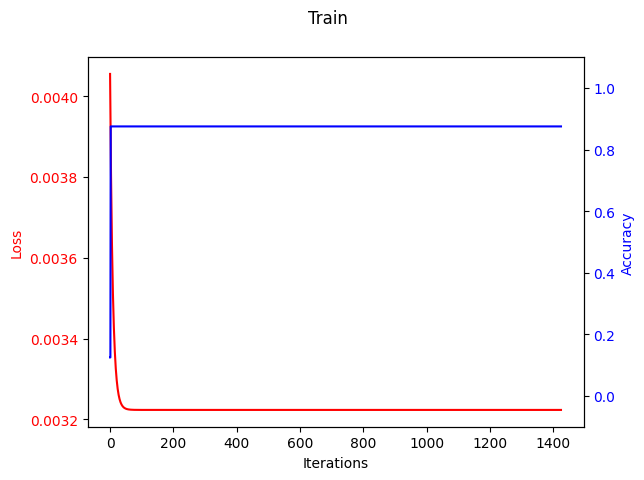

In [493]:
fig, ax1 = plt.subplots()
fig.suptitle("Train")

ax1.plot(range(len(train_loss)), train_loss, color="red")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss", color="red")
ax1.tick_params(axis="y", labelcolor="red")

ax2 = ax1.twinx()
ax2.plot(range(len(train_accuracy)), train_accuracy, color="blue")
ax2.set_ylabel("Accuracy", color="blue")
ax2.set_ylim(bottom=-0.1, top=1.1)
ax2.tick_params(axis="y", labelcolor="blue")

In [494]:
print(train_accuracy[-1].item())
print(1 - next(iter(train_dataloader))[1].mean().item())

0.875
0.875


The learned parameters are not simmetric at all, the converge to the same value everywhere

In [495]:
list(model.parameters())

[Parameter containing:
 tensor([[0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018],
         [0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([0.0036, 0.0036], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0855, -0.0855]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.1702], device='cuda:0', requires_grad=True)]

## Other Parameters
We try to use the momentum instead of the weight_decay and increasing the learning rate

In [69]:
model: th.nn.Module = generate_model(X.shape[1]).to(device)

In [70]:
init_parameters_uniform(model, boundary=0.3)

In [71]:
# optimizer: th.optim.Optimizer = th.optim.Adam(model.parameters(), lr=1, weight_decay=0.5)
optimizer: th.optim.Optimizer = th.optim.SGD(model.parameters(), lr=1, momentum=0.9)

### Train

In [72]:
train_loss, train_accuracy, test_loss, test_accuracy = train_routine(model, CRITERION, optimizer, train_dataloader, test_dataloader, epochs=1245)

  0%|          | 0/1245 [00:00<?, ?it/s]

From this configuration we can notice that the model is able to learn the simmetry

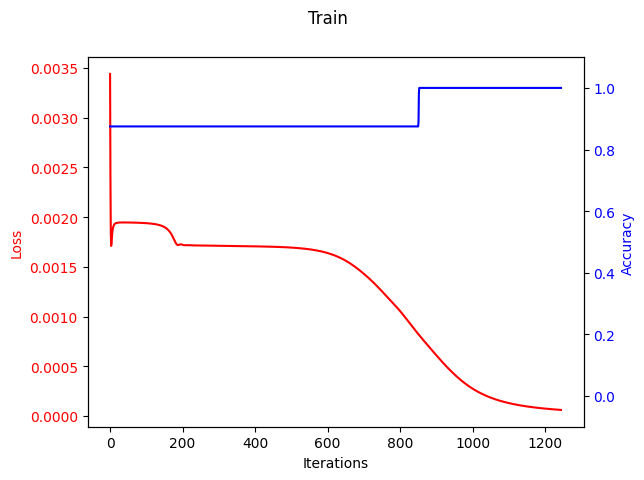

In [73]:
fig, ax1 = plt.subplots()
fig.suptitle("Train")

ax1.plot(range(len(train_loss)), train_loss, color="red")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss", color="red")
ax1.tick_params(axis="y", labelcolor="red")

ax2 = ax1.twinx()
ax2.plot(range(len(train_accuracy)), train_accuracy, color="blue")
ax2.set_ylabel("Accuracy", color="blue")
ax2.set_ylim(bottom=-0.1, top=1.1)
ax2.tick_params(axis="y", labelcolor="blue")

In [74]:
print(train_accuracy[-1].item())
print(1 - next(iter(train_dataloader))[1].mean().item())

1.0
0.875


In [75]:
list(model.parameters())

[Parameter containing:
 tensor([[-9.3558,  4.7085, -2.3654,  2.3627, -4.7103,  9.3542],
         [ 9.3152, -4.6908,  2.3527, -2.3558,  4.6889, -9.3169]],
        requires_grad=True),
 Parameter containing:
 tensor([-1.8655, -1.8582], requires_grad=True),
 Parameter containing:
 tensor([[-11.5967, -11.6094]], requires_grad=True),
 Parameter containing:
 tensor([5.0260], requires_grad=True)]

# Conclusions

We tried to implement the network suggested from the paper, composed by one hidden layer with two hidden units, and just one output. This was done using fully conntected layers. \\

The used loss function is the Mean Square Error, while the optimizer is the classical Stochastic Gradient Descent using a weigth decay of 0.9 and a learning rate of 0.1. \\

The batch size is equal to the size of the dataset, which is 64.
As a test set we use the whole train-set, due to the lack of data.
In the end, the parameters are initialized uniformly between -0.3 and 0.3. \\

From the implementation of the network suggested from the paper, we can notice that the obtained model is nothing else than a dummy classifier, because classify all the elements with the same class. \\

This is probably due to the high umbalancing of the data, which will contain just 64 rows, from which just 8 are simmetric, which means 12.5% of the dataset. We have also that the parameters seems to converge all to the same value. \\

This problem is solvable increasing the learning rate, this because the loss function is probably contains several local minima. Increase the learning rate can increase the probability to go out from the local minima, but give also the possibility to bounce without reaching the global minimum.
To help this process to reach better minima, we can use the momentum which will reduce the bouncing through the walls. \\

We can see that using this approach the model is able to reach the maximum accuracy and obtain simmetrical parameters. These, of course, are different from the ones found from the paper, but they are consistent with their results. \\

So we can conclude that the parameters and strategies suggested from the paper are not enough to find the requested results, because the model will be stuck into local minima. The solutions can be found using some strategies which push the parameters away from the minima introducing some noise, e.g. which could be a smaller batch, but in this case we probably should balance the dataset otherwise we could obtain batches without simmetric values, or, like seen before, introducing the momentum.